In [8]:
using HarmonicBalance
import HarmonicBalance.TimeEvolution: ParameterSweep, ODEProblem, solve

# Harmonic equations for the parametric oscillator

In [2]:
@variables ω0, γ, λ, F, x, θ, η, α, ω, t, x(t)

natural_equation =  d(x,t,2) + γ*d(x,t) + ω0^2*(1-λ*cos(2*ω*t))*x + α*x^3 + η*d(x,t)*x^2
force =  F*cos(ω*t+θ)
dEOM = DifferentialEquation(natural_equation + force, x)
add_harmonic!(dEOM, x, ω); # single-frequency ansatz

# construct the harmonic equations
harmonic_eq = get_harmonic_equations(dEOM)

A set of 2 harmonic equations
Variables: u1(T), v1(T)
Parameters: α, ω, F, θ, γ, η, ω0, λ

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt)

Harmonic equations:

(ω0^2)*u1(T) + F*cos(θ) + γ*Differential(T)(u1(T)) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^2)*u1(T) + (1//4)*η*ω*(v1(T)^3) + (3//4)*η*(u1(T)^2)*Differential(T)(u1(T)) + (1//4)*η*(v1(T)^2)*Differential(T)(u1(T)) + (1//4)*η*ω*(u1(T)^2)*v1(T) + (1//2)*η*u1(T)*v1(T)*Differential(T)(v1(T)) - (ω^2)*u1(T) - (1//2)*λ*(ω0^2)*u1(T) ~ 0

γ*Differential(T)(v1(T)) + (ω0^2)*v1(T) + (3//4)*α*(v1(T)^3) + (1//2)*λ*(ω0^2)*v1(T) + (1//4)*η*(u1(T)^2)*Differential(T)(v1(T)) + (3//4)*α*(u1(T)^2)*v1(T) + (3//4)*η*(v1(T)^2)*Differential(T)(v1(T)) + (1//2)*η*u1(T)*v1(T)*Differential(T)(u1(T)) - F*sin(θ) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - (1//4)*η*ω*(u1(T)^3) - γ*ω*u1(T) - (1//4)*η*ω*(v1(T)^2)*u1(T) ~ 0


### first let's see the steady state diagram

Tracking 9 paths... 100%|███████████████████████████████| Time: 0:00:14
  # paths tracked:                  9
  # non-singular solutions (real):  5 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         5 (0)


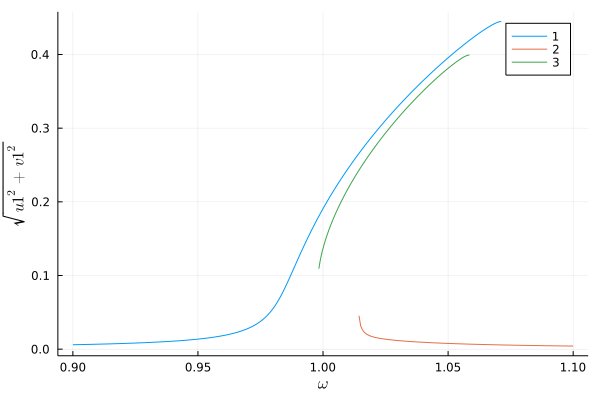

In [3]:
fixed = (ω0 => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1.,  η=>0.3, θ => 0)
varied = ω => LinRange(0.9, 1.1, 300)
result = get_steady_states(harmonic_eq, varied, fixed)
plot(result, "sqrt(u1^2 + v1^2)", class=["physical", "stable"])

# single sweep

In [9]:
sweep = ParameterSweep(ω=>(0.9, 1.1), (0, 2E4)) # linearly interpolate between two values at two times
ode_problem = ODEProblem(harmonic_eq, fixed, sweep=sweep, x0=[0.2;0.2], timespan=(0, 2E4))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 20000.0)
u0: 2-element Vector{Float64}:
 0.2
 0.2

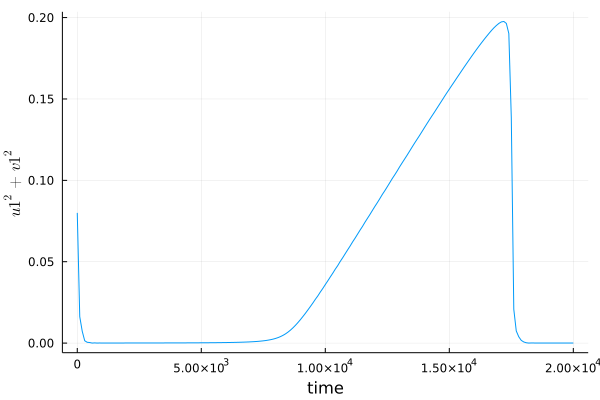

In [10]:
time_soln = solve(ode_problem, saveat=100);
plot(time_soln, "u1^2 + v1^2", harmonic_eq)

## simultaneous sweep of multiple parameters

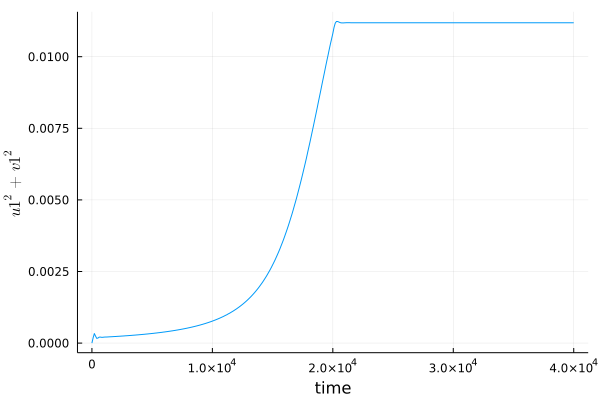

In [11]:
# interpolate both parameters
sw_params = [ω=>[0.95;1.0],λ => [5E-2;1E-2]]
sweep = ParameterSweep(sw_params, (0, 2E4))

ode_problem = ODEProblem(harmonic_eq, fixed, sweep=sweep,
    x0=[0.0001;0.0001], timespan=(0,4E4))

time_soln = solve(ode_problem,saveat=100);
plot(time_soln, "u1^2 + v1^2", harmonic_eq)

# series of sweeps

In [12]:
# combine two sweeps
sweep1 = ParameterSweep(ω => [0.95, 1.0], (0, 2E4))
sweep2 = ParameterSweep(λ => [0.05, 0.01], (2E4, 4E4))
sweep = sweep1 + sweep2

fixed_parameters = (ω0 => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1.,  η=>0.3, θ => 0)

ode_problem = ODEProblem(harmonic_eq, fixed, sweep=sweep, x0=[0.0001;0.0001], timespan=(0, 4E4));

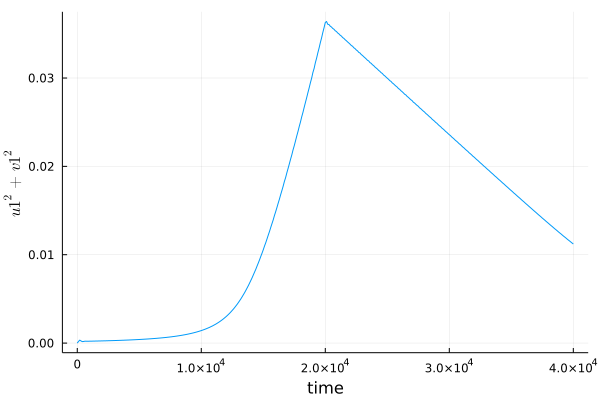

In [13]:
time_soln = solve(ode_problem,saveat=100);
plot(time_soln, "u1^2 + v1^2", harmonic_eq)

In [14]:
# check out our swept function
times = 0:4E4
plot(times, sweep[ω].(times));

# Define custom sweep functions

In [15]:
times = 0:2E4
ωfunc(t)=1-0.05*cos(2*pi*t/times[end])
λfunc(t)=0.05-0.027*sin(2*pi*t/times[end])
sweep_circle=ParameterSweep([ω => ωfunc,λ => λfunc])
# check the swept functions
plot((sweep_circle[ω].(times)),(sweep_circle[λ].(times)));

In [17]:
ode_problem = ODEProblem(harmonic_eq, fixed,sweep=sweep_circle; x0=[0.0001;0.0001], timespan=(0, 2E4))
@time time_soln = solve(ode_problem,saveat=100);
plot(time_soln, "u1^2 + v1^2", harmonic_eq);

  4.978185 seconds (16.69 M allocations: 627.914 MiB, 4.54% gc time)


# Use steady-state solutions as initial conditions

In [18]:
range = ParameterRange(ω => LinRange(1.03,1.1,100))
steady_soln = get_steady_states(harmonic_eq, range, fixed)

A steady state result for 100 parameter points

Solution branches:   5
   of which real:    5
   of which stable:  3

Classes: stable, physical, Hopf, binary_labels


In [19]:
# select a solution and evolve from it
s1 = get_single_solution(steady_soln, branch=1, index=1);
s2 = get_single_solution(steady_soln, branch=2, index=1);
s3 = get_single_solution(steady_soln, branch=3, index=1);

sweep = ParameterSweep(ω => (1.03, 1.1), (0, 1E4))
function t_solve(s)
    problem = ODEProblem(harmonic_eq, s, timespan=(0,1E4), sweep=sweep)
    time_soln = solve(problem,saveat=10);
end

t_solve (generic function with 1 method)

In [20]:
# time-evolve all three solutions
time_soln_1 = t_solve(s1)
time_soln_2 = t_solve(s2)
time_soln_3 = t_solve(s3);

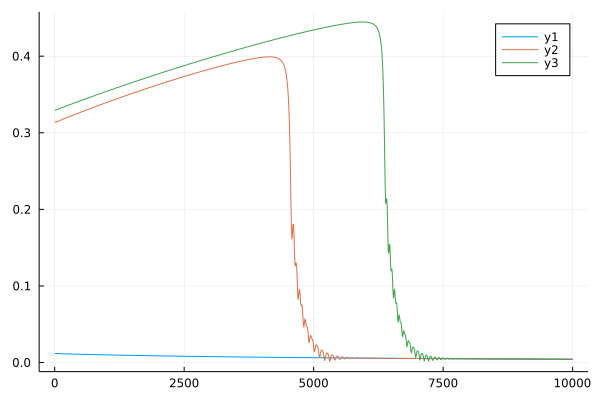

In [35]:
# contrast to steady-state solution
plot_td(s) = plot!(s.t, sqrt.(getindex.(s.u,1).^2 .+ getindex.(s.u,2).^2))
plot_td(time_soln_1)
plot_td(time_soln_2)
plot_td(time_soln_3)

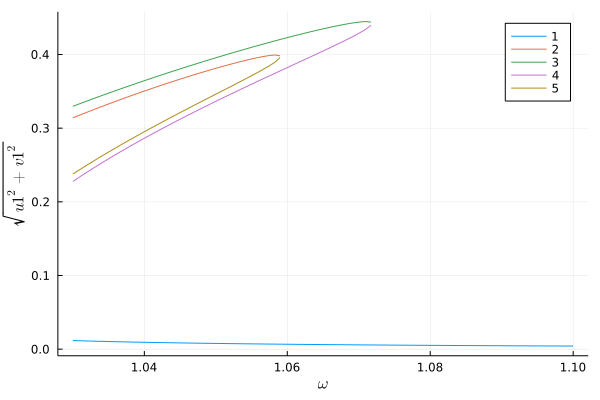

In [36]:
plot(steady_soln, x="ω", y="sqrt(u1^2 + v1^2)")